# Simple RNN

Epoch 1/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - accuracy: 0.3082 - loss: 2.8151 - val_accuracy: 0.5637 - val_loss: 0.5511
Epoch 2/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 81s 160ms/step - accuracy: 0.5681 - loss: 0.4752 - val_accuracy: 0.5892 - val_loss: 0.3003
Epoch 3/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.5895 - loss: 0.2727 - val_accuracy: 0.5944 - val_loss: 0.2269
Epoch 4/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.5995 - loss: 0.2013 - val_accuracy: 0.5971 - val_loss: 0.1901
Epoch 5/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 78s 154ms/step - accuracy: 0.6002 - loss: 0.1658 - val_accuracy: 0.5983 - val_loss: 0.1653
Epoch 6/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.5997 - loss: 0.1455 - val_accuracy: 0.5982 - val_loss: 0.1561
Epoch 7/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 75s 157ms/step - accuracy: 0.6005 - loss: 0.1315 - val_accuracy: 0.5991 - val_loss: 0.1462
Epoch 8/10
478/478 ━━━━━━━━━━━━━━━━━━━━ 75s 156ms/step - accuracy: 0.6016 - loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           $       1.00      1.00      1.00       112
           ,       1.00      1.00      1.00      3161
           .       1.00      1.00      1.00      4763
           :       0.76      0.90      0.82        88
           ;       0.95      1.00      0.97        18
          CC       1.00      1.00      1.00      2376
          CD       0.99      0.94      0.97      2442
          DT       1.00      1.00      1.00      9697
          EX       0.95      1.00      0.98        60
          IN       1.00      0.99      0.99     11991
          JJ       0.94      0.92      0.93      7646
         JJR       0.91      0.98      0.94       277
         JJS       0.95      0.96      0.96       310
         LRB       1.00      0.97      0.99        73
          MD       1.00      1.00      1.00       676
          NN       0.96      0.95      0.96     14400
         NNP       0.93      0.98      0.95     12767
        NNPS       0.88    

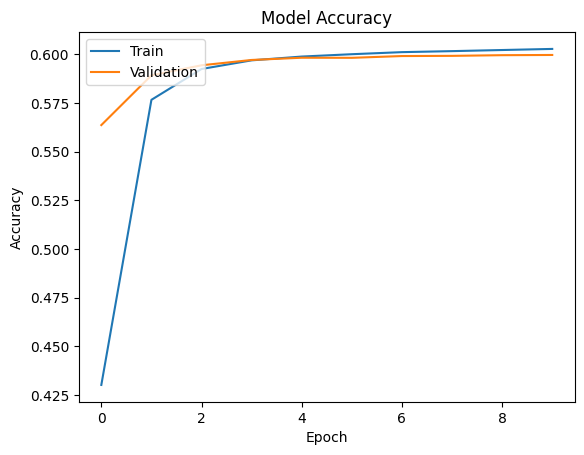

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from numpy import percentile

def load_data(file_path):
    sentences = []
    sentence = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                word, tag = line.split('\t')
                sentence.append((word, tag))
        if sentence:
            sentences.append(sentence)
    return sentences

train_sentences = load_data(r'/content/preprocessed_dataset_train.txt')
test_sentences = load_data(r'/content/preprocessed_dataset_test.txt')
word_counts = {}

tag_set = {'PAD'}

for sentence in train_sentences:
    for word, tag in sentence:
        word_counts[word] = word_counts.get(word, 0) + 1
        tag_set.add(tag)

vocab = ['<PAD>', '<UNK>'] + [word for word, count in word_counts.items() if count >= 2]
tag_list = sorted(tag_set)

word2idx = {word: idx for idx, word in enumerate(vocab)}
tag2idx = {tag: idx for idx, tag in enumerate(tag_list)}

def encode(sentences, word2idx, tag2idx):
    X = []
    y = []
    for sentence in sentences:
        x_seq = []
        y_seq = []
        for word, tag in sentence:
            x_seq.append(word2idx.get(word, word2idx['<UNK>']))
            y_seq.append(tag2idx[tag])
        X.append(x_seq)
        y.append(y_seq)
    return X, y

X_train, y_train = encode(train_sentences, word2idx, tag2idx)
X_test, y_test = encode(test_sentences, word2idx, tag2idx)


pad_tag_idx = tag2idx['PAD']

max_len = int(percentile([len(s) for s in train_sentences], 95))

X_train = pad_sequences(X_train, maxlen=max_len, padding='post', value=word2idx['<PAD>'])
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', value=word2idx['<PAD>'])
y_train = pad_sequences(y_train, maxlen=max_len, padding='post', value=pad_tag_idx)
y_test = pad_sequences(y_test, maxlen=max_len, padding='post', value=pad_tag_idx)

num_tags = len(tag_list)
y_train = utils.to_categorical(y_train, num_classes=num_tags)
y_test = utils.to_categorical(y_test, num_classes=num_tags)


def build_model(vocab_size, num_tags, embedding_dim=128, lstm_units=256):
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True))


    model.add(layers.Bidirectional(
        layers.SimpleRNN(lstm_units, return_sequences=True, kernel_regularizer='l2')
    ))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_tags, activation='softmax'))
    return model

model = build_model(len(vocab), num_tags)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


def flatten_preds(y_true, y_pred):
    y_true_flat = np.argmax(y_true.reshape(-1, num_tags), axis=1)
    y_pred_flat = np.argmax(y_pred.reshape(-1, num_tags), axis=1)


    mask = y_true_flat != tag2idx['PAD']

    return y_true_flat[mask], y_pred_flat[mask]


y_pred = model.predict(X_test)
y_true_flat, y_pred_flat = flatten_preds(y_test, y_pred)

valid_tags = np.unique(y_true_flat)
valid_tag_names = [tag_list[idx] for idx in valid_tags]


print(classification_report(
    y_true_flat,
    y_pred_flat,
    labels=valid_tags,
    target_names=valid_tag_names
))


print("\nWeighted F1 Score:", f1_score(y_true_flat, y_pred_flat, average='weighted'))
print("Macro F1 Score:", f1_score(y_true_flat, y_pred_flat, average='macro'))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [3]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_flat, y_pred_flat))


Confusion Matrix:
[[ 112    0    0 ...    0    0    0]
 [   0 3161    0 ...    0    0    0]
 [   0    0 4763 ...    0    0    0]
 ...
 [   0    0    0 ...    8    0    0]
 [   0    0    0 ...    0  215    0]
 [   0    0    0 ...    0    0  386]]
